In [1]:
from IPython.core.display import HTML
HTML("""
<style>

div.cell { /* Tunes the space between cells */
margin-top:1em;
margin-bottom:1em;
}

div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 1.6em;
line-height:1.4em
text-align:center;
}

div.text_cell_render h2 { /*  Parts names nearer from text */
margin-bottom: -0.4em;
}


div.text_cell_render { /* Customize text cells */
font-family: 'Times New Roman';
font-size:1.3em;
line-height:1.4em;
padding-right:3em;
}
</style>
""")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline
from itertools import cycle, islice
import pylab as pl
import operator
import re
from collections import OrderedDict
import pickle
import matplotlib.colors as colors
import math
from scipy import stats

Populating the interactive namespace from numpy and matplotlib


In [36]:
#seaborn settings
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8,4)})

#set pandas so i can view all dataframne columns
pd.set_option('display.max_columns', None)

#import csv file
PTCAudit = pd.read_csv('PTCAudit.csv',low_memory=False)
PTCAudit.head()
PTCAudit.dtypes

Unnamed: 0                          int64
AGIFinal                           object
AUDIT_RESULT                       object
Agi_Comp                            int64
Annl_SLCSP_Prem_Comp                int64
Annual_Contrib_Health_Care_Amt      int64
Aptc_Amt_Comp                       int64
Aptc_Amt_From_1040                  int64
Bal_Due_Amt_Comp                    int64
Bal_Due_Amt_CompFinal              object
Bod_Cd                             object
City                               object
Current_Ty_Exemptions               int64
Cycle_Scored                        int64
DISP_CD                             int64
Ddb_Ptc_900_Cdb                     int64
Ddb_Ptc_901_Cdb                     int64
Ddb_Ptc_902_Cdb                     int64
Ddb_Ptc_903_Cdb                     int64
Ddb_Ptc_904_Cdb                     int64
Ddb_Ptc_910_Cdb                     int64
Ddb_Ptc_911_Cdb                     int64
Ddb_Ptc_912_Cdb                     int64
Ddb_Ptc_913_Cdb                   

In [41]:
PTCAudit['AGIFinal2'] = PTCAudit['AGIFinal'].astype('float')
PTCAudit.dtypes

ValueError: could not convert string to float: '4-$20,001 to $30,000'

Automatic Feature Selection

Often we collected many features that might be related to a supervised prediction task, but we don't know which of them are actually predictive. To improve interpretability, and sometimes also generalization performance, we can use automatic feature selection to select a subset of the original features. There are several types of feature selection methods available, which we'll explain in order of increasing complexity.

For a given supervised model, the best feature selection strategy would be to try out each possible subset of the features, and evaluate generalization performance using this subset. However, there are exponentially many subsets of features, so this exhaustive search is generally infeasible. The strategies discussed below can be thought of as proxies for this infeasible computation.

Model-based Feature Selection

A somewhat more sophisticated method for feature selection is using a supervised machine learning model and selecting features based on how important they were deemed by the model. This requires the model to provide some way to rank the features by importance. This can be done for all tree-based models (which implement get_feature_importances) and all linear models, for which the coefficients can be used to determine how much influence a feature has on the outcome.

Any of these models can be made into a transformer that does feature selection by wrapping it with the SelectFromModel class:

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into a training and test set.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(PTCAudit[[ 'Agi_Comp','Family_Size', 'Filing_Status','First_Time_Filer','Ptc_Magi_Amt']].values, 
                                              (PTCAudit.AUDIT_RESULT == "BADRETURN").values,random_state=5)

clf = LogisticRegression()
# Fit the model on the trainng data.
clf.fit(Xlr, ylr)
# Print the accuracy from the training and testing data.
print(accuracy_score(clf.predict(Xlr), ylr))
print(accuracy_score(clf.predict(Xtestlr), ytestlr))

0.705436156764
0.698578199052


In [16]:
from sklearn.model_selection import train_test_split

X, y = PTCAudit[["Agi_Comp", "Ptc_Err_190_Cdb"]], PTCAudit["AUDIT_RESULT"]

train_X, test_X, train_y, test_y = train_test_split(X, y)

print("Labels for training and testing data")
print(train_y)
print(test_y)

Labels for training and testing data
1007     BADRETURN
7526     BADRETURN
1818    GOODRETURN
1022    GOODRETURN
1049     BADRETURN
5760     BADRETURN
6198    GOODRETURN
5191    GOODRETURN
1706     BADRETURN
6291    GOODRETURN
752     GOODRETURN
271      BADRETURN
7005     BADRETURN
6585     BADRETURN
3353     BADRETURN
316      BADRETURN
4512     BADRETURN
659      BADRETURN
1424    GOODRETURN
1018     BADRETURN
2638    GOODRETURN
4534    GOODRETURN
5498    GOODRETURN
2003     BADRETURN
3050     BADRETURN
892      BADRETURN
2952     BADRETURN
5369     BADRETURN
7104    GOODRETURN
6625     BADRETURN
           ...    
7924     BADRETURN
3125     BADRETURN
4306     BADRETURN
1703     BADRETURN
115      BADRETURN
1380     BADRETURN
8433    GOODRETURN
7556     BADRETURN
8435     BADRETURN
3555    GOODRETURN
1931     BADRETURN
3193    GOODRETURN
7515    GOODRETURN
3765    GOODRETURN
4452     BADRETURN
3307     BADRETURN
4328     BADRETURN
4796     BADRETURN
1945     BADRETURN
1182     BADR

In [14]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
select = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold="median")

In [18]:
select.fit(train_X, train_y)
X_train_rf = select.transform(train_X)
print(train_X.shape)
print(X_train_rf.shape)

(6328, 2)
(6328, 1)


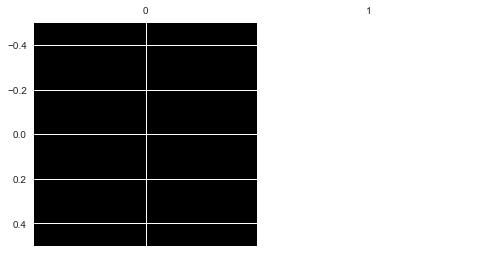

In [19]:
mask = select.get_support()
# visualize the mask. black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')

In [21]:
X_test_rf = select.transform(test_X)
LogisticRegression().fit(X_train_rf, train_y).score(X_test_rf, test_y)

0.68862559241706156

This method builds a single model (in this case a random forest) and uses the feature importances from this model. We can do a somewhat more elaborate search by training multiple models on subsets of the data. One particular strategy is recursive feature elimination:

Recursive Feature Elimination

Recursive feature elimination builds a model on the full set of features, and similar to the method above selects a subset of features that are deemed most important by the model. However, usually only a single feature is dropped from the dataset, and a new model is built with the remaining features. The process of dropping features and model building is repeated until there are only a pre-specified number of features left:

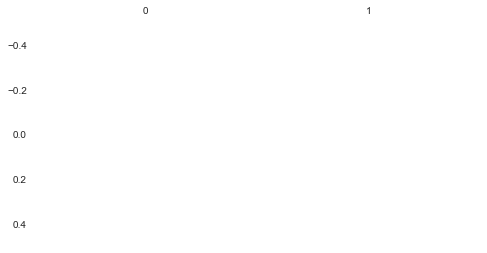

In [27]:
from sklearn.feature_selection import RFE
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=40)

select.fit(train_X, train_y)
# visualize the selected features:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')

In [28]:
X_train_rfe = select.transform(train_X)
X_test_rfe = select.transform(test_X)

LogisticRegression().fit(X_train_rfe, train_y).score(X_test_rfe, test_y)

0.68862559241706156

In [29]:
select.score(test_X, test_y)

0.63222748815165875